In [20]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time

from keras.datasets import fashion_mnist
from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential

In [21]:
#Load Data
(xTrain,_),(_,_) = fashion_mnist.load_data()

In [22]:
#reshape and normalise data
xTrain = xTrain.reshape(xTrain.shape[0],28,28,1).astype("float32")
xTrain = xTrain/127.5-1.0 #tanh -->[-1,1]
len(xTrain)

60000

In [23]:
batchSize = 256
trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [24]:
nepochs = 50
zDim = 100
imgShape = (28,28,1)
sampleInterval = 1

In [25]:
def buildGenerator():

    model = Sequential()
    model.add(Dense(256 * 7 * 7,  input_shape=(zDim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape([7, 7, 256]))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [26]:
buildGenerator().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_8 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 14, 14, 128)     

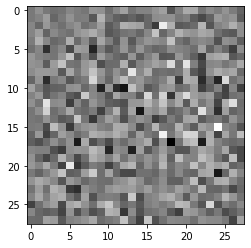

In [27]:
#generate noise image
generator = buildGenerator()

noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5, cmap = "gray")
plt.show()


In [28]:
#Discriminator
def buildDiscriminator():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [29]:
buildDiscriminator().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)        

In [30]:
#classyfy with discriminator
discriminator = buildDiscriminator()
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[0.49997723]], shape=(1, 1), dtype=float32)


In [31]:
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [32]:
buildGan(generator,discriminator).summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28, 1)         1705601   
                                                                 
 sequential_9 (Sequential)   (None, 1)                 388865    
                                                                 
Total params: 2,094,466
Trainable params: 2,068,930
Non-trainable params: 25,536
_________________________________________________________________


In [33]:
gan = buildGan(generator,discriminator)
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[0.49997723]], shape=(1, 1), dtype=float32)


In [34]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [35]:
def train_step(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])
    #for i in range(3):
    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)
    disLoss, acc = 0.5*tf.add(dreal,dfake)
    
    discriminator.trainable = False
    genLoss = gan.train_on_batch(noise,real)

      
    return genLoss,disLoss,acc*100

In [36]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [37]:
def sampleImg(generator,imgGridRow = 5, imgGridColumn = 5):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 1 is 49.0 sec
Epoch:  1 | Discriminator Loss:  0.13 | Accuracy:  95.83 % | Generator Loss:  4.5
---------------------------------------------------------------------------------------------------------------------------------------------------------------


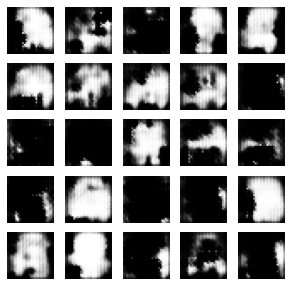

Time for epoch 2 is 47.0 sec
Epoch:  2 | Discriminator Loss:  0.04 | Accuracy:  98.96 % | Generator Loss:  5.18
---------------------------------------------------------------------------------------------------------------------------------------------------------------


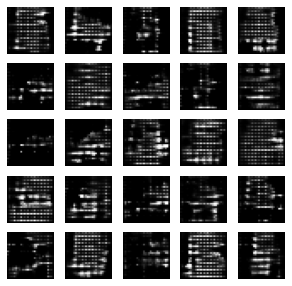

Time for epoch 3 is 47.0 sec
Epoch:  3 | Discriminator Loss:  0.11 | Accuracy:  95.83 % | Generator Loss:  7.28
---------------------------------------------------------------------------------------------------------------------------------------------------------------


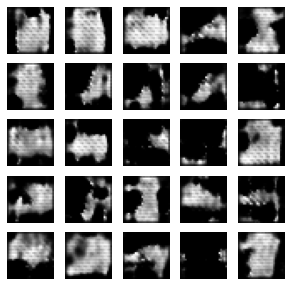

Time for epoch 4 is 47.0 sec
Epoch:  4 | Discriminator Loss:  0.2 | Accuracy:  90.1 % | Generator Loss:  2.63
---------------------------------------------------------------------------------------------------------------------------------------------------------------


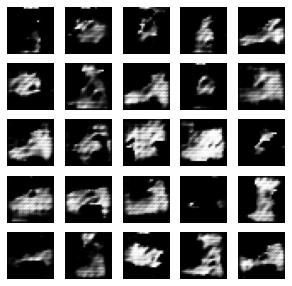

Time for epoch 5 is 47.0 sec
Epoch:  5 | Discriminator Loss:  0.05 | Accuracy:  98.96 % | Generator Loss:  8.77
---------------------------------------------------------------------------------------------------------------------------------------------------------------


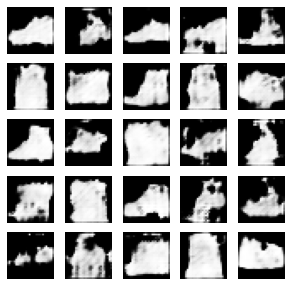

Time for epoch 6 is 47.0 sec
Epoch:  6 | Discriminator Loss:  0.05 | Accuracy:  98.44 % | Generator Loss:  3.17
---------------------------------------------------------------------------------------------------------------------------------------------------------------


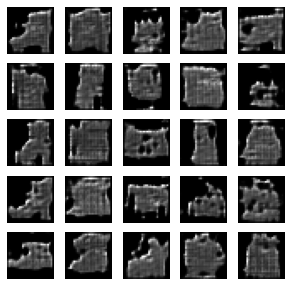

Time for epoch 7 is 47.0 sec
Epoch:  7 | Discriminator Loss:  0.13 | Accuracy:  93.75 % | Generator Loss:  5.62
---------------------------------------------------------------------------------------------------------------------------------------------------------------


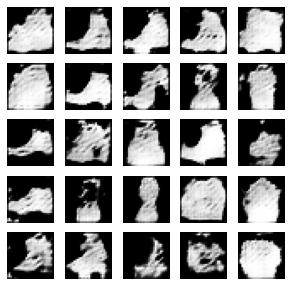

Time for epoch 8 is 47.0 sec
Epoch:  8 | Discriminator Loss:  0.13 | Accuracy:  95.83 % | Generator Loss:  4.69
---------------------------------------------------------------------------------------------------------------------------------------------------------------


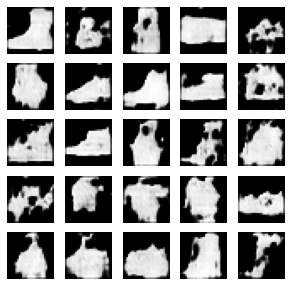

Time for epoch 9 is 47.0 sec
Epoch:  9 | Discriminator Loss:  0.2 | Accuracy:  92.71 % | Generator Loss:  3.23
---------------------------------------------------------------------------------------------------------------------------------------------------------------


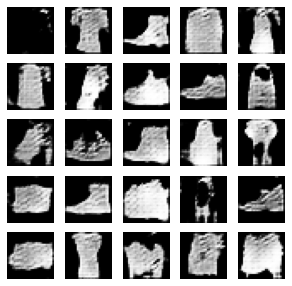

Time for epoch 10 is 47.0 sec
Epoch:  10 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  7.16
---------------------------------------------------------------------------------------------------------------------------------------------------------------


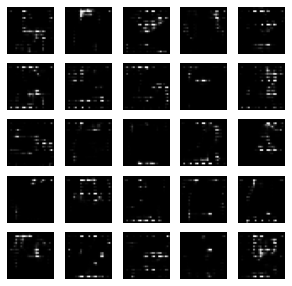

Time for epoch 11 is 47.0 sec
Epoch:  11 | Discriminator Loss:  0.05 | Accuracy:  98.96 % | Generator Loss:  7.21
---------------------------------------------------------------------------------------------------------------------------------------------------------------


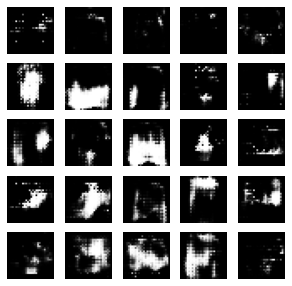

Time for epoch 12 is 47.0 sec
Epoch:  12 | Discriminator Loss:  0.22 | Accuracy:  89.58 % | Generator Loss:  4.09
---------------------------------------------------------------------------------------------------------------------------------------------------------------


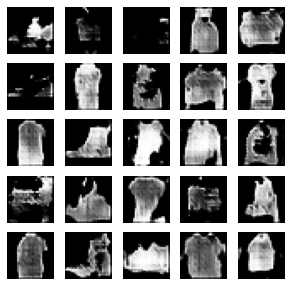

Time for epoch 13 is 47.0 sec
Epoch:  13 | Discriminator Loss:  0.16 | Accuracy:  93.23 % | Generator Loss:  3.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


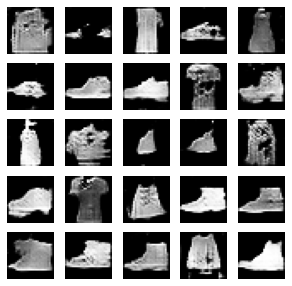

Time for epoch 14 is 48.0 sec
Epoch:  14 | Discriminator Loss:  0.28 | Accuracy:  88.54 % | Generator Loss:  3.06
---------------------------------------------------------------------------------------------------------------------------------------------------------------


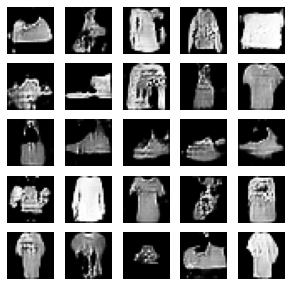

Time for epoch 15 is 47.0 sec
Epoch:  15 | Discriminator Loss:  0.4 | Accuracy:  85.42 % | Generator Loss:  2.44
---------------------------------------------------------------------------------------------------------------------------------------------------------------


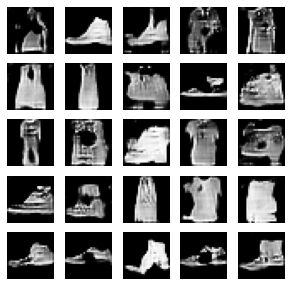

Time for epoch 16 is 48.0 sec
Epoch:  16 | Discriminator Loss:  0.41 | Accuracy:  80.21 % | Generator Loss:  2.2
---------------------------------------------------------------------------------------------------------------------------------------------------------------


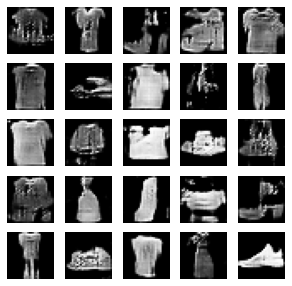

Time for epoch 17 is 48.0 sec
Epoch:  17 | Discriminator Loss:  0.47 | Accuracy:  77.08 % | Generator Loss:  2.27
---------------------------------------------------------------------------------------------------------------------------------------------------------------


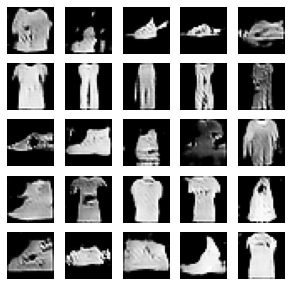

Time for epoch 18 is 48.0 sec
Epoch:  18 | Discriminator Loss:  0.37 | Accuracy:  83.33 % | Generator Loss:  2.06
---------------------------------------------------------------------------------------------------------------------------------------------------------------


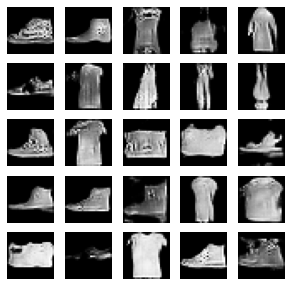

Time for epoch 19 is 47.0 sec
Epoch:  19 | Discriminator Loss:  0.43 | Accuracy:  80.21 % | Generator Loss:  2.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


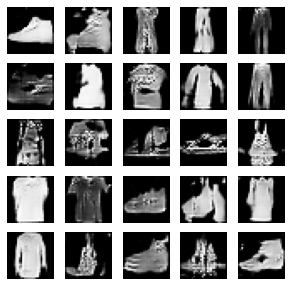

Time for epoch 20 is 47.0 sec
Epoch:  20 | Discriminator Loss:  0.46 | Accuracy:  76.56 % | Generator Loss:  1.59
---------------------------------------------------------------------------------------------------------------------------------------------------------------


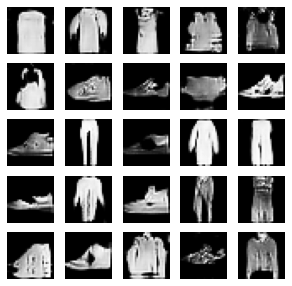

Time for epoch 21 is 47.0 sec
Epoch:  21 | Discriminator Loss:  0.39 | Accuracy:  80.73 % | Generator Loss:  1.88
---------------------------------------------------------------------------------------------------------------------------------------------------------------


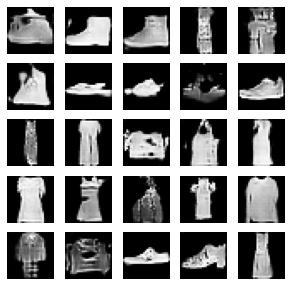

Time for epoch 22 is 47.0 sec
Epoch:  22 | Discriminator Loss:  0.4 | Accuracy:  80.73 % | Generator Loss:  1.74
---------------------------------------------------------------------------------------------------------------------------------------------------------------


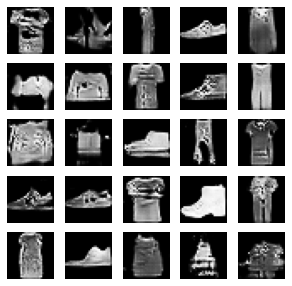

Time for epoch 23 is 47.0 sec
Epoch:  23 | Discriminator Loss:  0.39 | Accuracy:  83.33 % | Generator Loss:  1.95
---------------------------------------------------------------------------------------------------------------------------------------------------------------


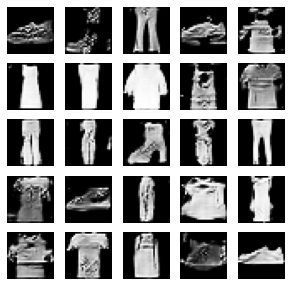

Time for epoch 24 is 47.0 sec
Epoch:  24 | Discriminator Loss:  0.39 | Accuracy:  83.85 % | Generator Loss:  2.08
---------------------------------------------------------------------------------------------------------------------------------------------------------------


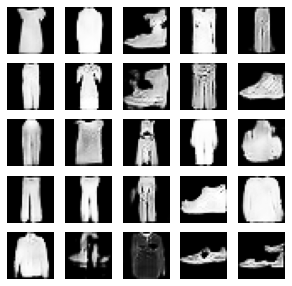

Time for epoch 25 is 47.0 sec
Epoch:  25 | Discriminator Loss:  0.42 | Accuracy:  80.73 % | Generator Loss:  1.81
---------------------------------------------------------------------------------------------------------------------------------------------------------------


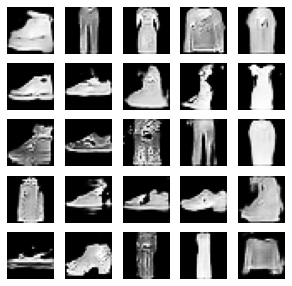

Time for epoch 26 is 48.0 sec
Epoch:  26 | Discriminator Loss:  0.42 | Accuracy:  80.21 % | Generator Loss:  1.8
---------------------------------------------------------------------------------------------------------------------------------------------------------------


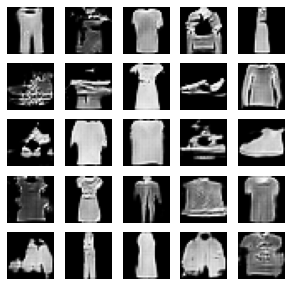

Time for epoch 27 is 48.0 sec
Epoch:  27 | Discriminator Loss:  0.42 | Accuracy:  77.08 % | Generator Loss:  1.71
---------------------------------------------------------------------------------------------------------------------------------------------------------------


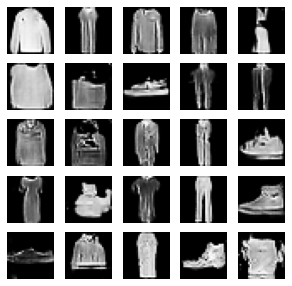

Time for epoch 28 is 48.0 sec
Epoch:  28 | Discriminator Loss:  0.41 | Accuracy:  82.29 % | Generator Loss:  1.61
---------------------------------------------------------------------------------------------------------------------------------------------------------------


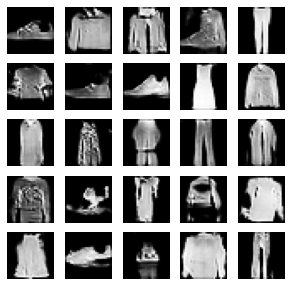

Time for epoch 29 is 47.0 sec
Epoch:  29 | Discriminator Loss:  0.42 | Accuracy:  83.33 % | Generator Loss:  2.09
---------------------------------------------------------------------------------------------------------------------------------------------------------------


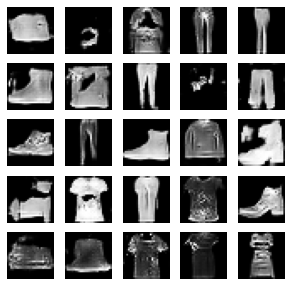

Time for epoch 30 is 47.0 sec
Epoch:  30 | Discriminator Loss:  0.4 | Accuracy:  83.85 % | Generator Loss:  1.5
---------------------------------------------------------------------------------------------------------------------------------------------------------------


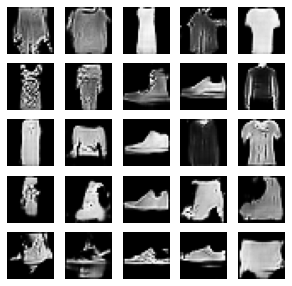

Time for epoch 31 is 47.0 sec
Epoch:  31 | Discriminator Loss:  0.48 | Accuracy:  75.52 % | Generator Loss:  1.77
---------------------------------------------------------------------------------------------------------------------------------------------------------------


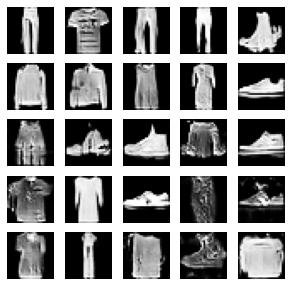

Time for epoch 32 is 48.0 sec
Epoch:  32 | Discriminator Loss:  0.45 | Accuracy:  78.12 % | Generator Loss:  1.72
---------------------------------------------------------------------------------------------------------------------------------------------------------------


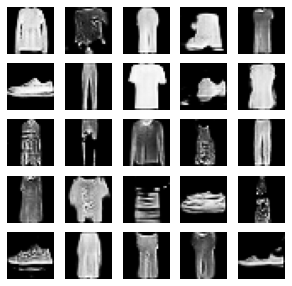

Time for epoch 33 is 47.0 sec
Epoch:  33 | Discriminator Loss:  0.45 | Accuracy:  80.73 % | Generator Loss:  1.82
---------------------------------------------------------------------------------------------------------------------------------------------------------------


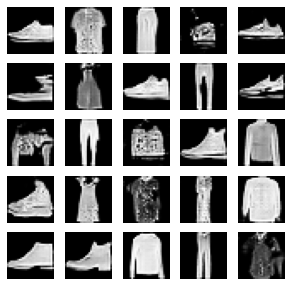

Time for epoch 34 is 47.0 sec
Epoch:  34 | Discriminator Loss:  0.51 | Accuracy:  73.44 % | Generator Loss:  1.51
---------------------------------------------------------------------------------------------------------------------------------------------------------------


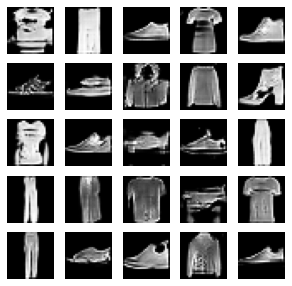

Time for epoch 35 is 47.0 sec
Epoch:  35 | Discriminator Loss:  0.43 | Accuracy:  81.77 % | Generator Loss:  1.51
---------------------------------------------------------------------------------------------------------------------------------------------------------------


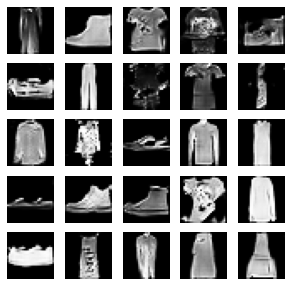

Time for epoch 36 is 47.0 sec
Epoch:  36 | Discriminator Loss:  0.47 | Accuracy:  79.17 % | Generator Loss:  1.7
---------------------------------------------------------------------------------------------------------------------------------------------------------------


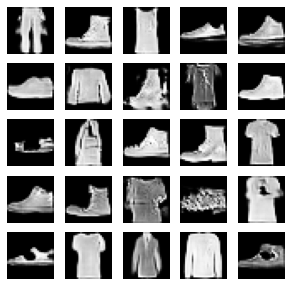

Time for epoch 37 is 47.0 sec
Epoch:  37 | Discriminator Loss:  0.47 | Accuracy:  76.04 % | Generator Loss:  1.8
---------------------------------------------------------------------------------------------------------------------------------------------------------------


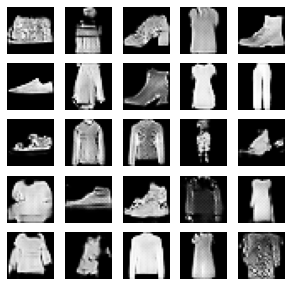

Time for epoch 38 is 47.0 sec
Epoch:  38 | Discriminator Loss:  0.51 | Accuracy:  75.52 % | Generator Loss:  1.42
---------------------------------------------------------------------------------------------------------------------------------------------------------------


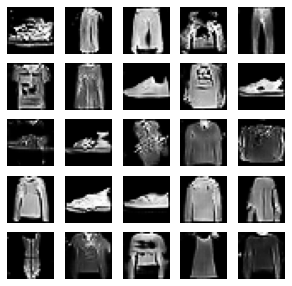

Time for epoch 39 is 47.0 sec
Epoch:  39 | Discriminator Loss:  0.52 | Accuracy:  69.79 % | Generator Loss:  1.49
---------------------------------------------------------------------------------------------------------------------------------------------------------------


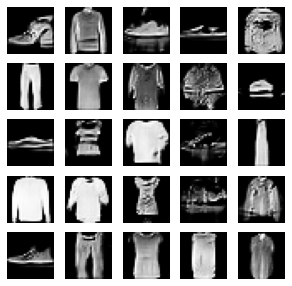

Time for epoch 40 is 48.0 sec
Epoch:  40 | Discriminator Loss:  0.5 | Accuracy:  77.08 % | Generator Loss:  1.64
---------------------------------------------------------------------------------------------------------------------------------------------------------------


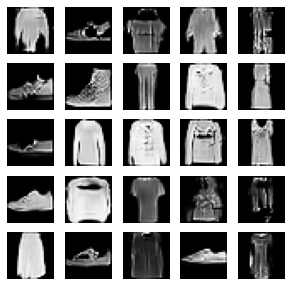

Time for epoch 41 is 47.0 sec
Epoch:  41 | Discriminator Loss:  0.49 | Accuracy:  75.0 % | Generator Loss:  1.53
---------------------------------------------------------------------------------------------------------------------------------------------------------------


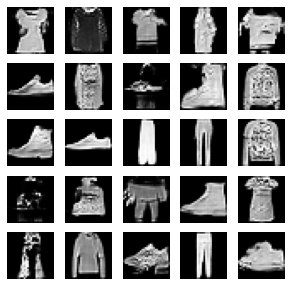

Time for epoch 42 is 48.0 sec
Epoch:  42 | Discriminator Loss:  0.58 | Accuracy:  68.75 % | Generator Loss:  1.24
---------------------------------------------------------------------------------------------------------------------------------------------------------------


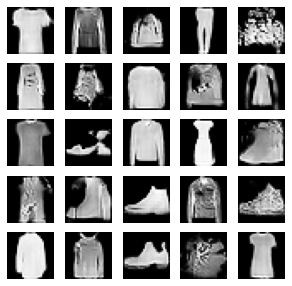

Time for epoch 43 is 48.0 sec
Epoch:  43 | Discriminator Loss:  0.52 | Accuracy:  74.48 % | Generator Loss:  1.55
---------------------------------------------------------------------------------------------------------------------------------------------------------------


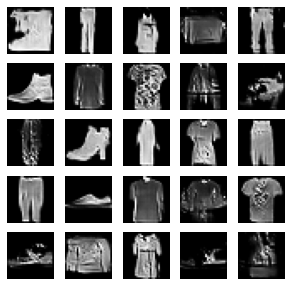

Time for epoch 44 is 48.0 sec
Epoch:  44 | Discriminator Loss:  0.49 | Accuracy:  72.92 % | Generator Loss:  1.38
---------------------------------------------------------------------------------------------------------------------------------------------------------------


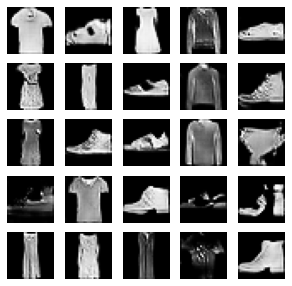

Time for epoch 45 is 48.0 sec
Epoch:  45 | Discriminator Loss:  0.44 | Accuracy:  77.08 % | Generator Loss:  1.75
---------------------------------------------------------------------------------------------------------------------------------------------------------------


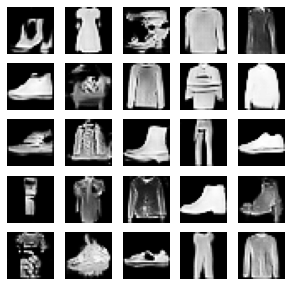

Time for epoch 46 is 48.0 sec
Epoch:  46 | Discriminator Loss:  0.54 | Accuracy:  70.31 % | Generator Loss:  1.5
---------------------------------------------------------------------------------------------------------------------------------------------------------------


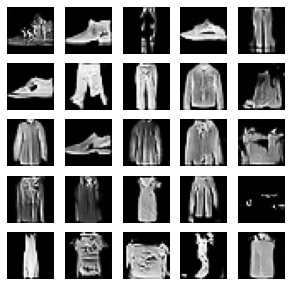

Time for epoch 47 is 48.0 sec
Epoch:  47 | Discriminator Loss:  0.49 | Accuracy:  71.88 % | Generator Loss:  1.6
---------------------------------------------------------------------------------------------------------------------------------------------------------------


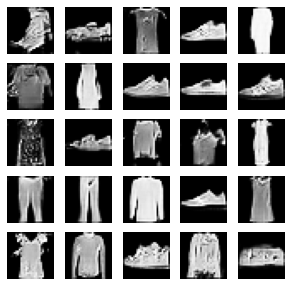

Time for epoch 48 is 48.0 sec
Epoch:  48 | Discriminator Loss:  0.48 | Accuracy:  76.56 % | Generator Loss:  1.45
---------------------------------------------------------------------------------------------------------------------------------------------------------------


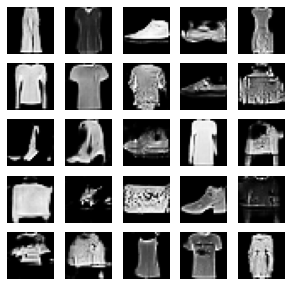

Time for epoch 49 is 50.0 sec
Epoch:  49 | Discriminator Loss:  0.56 | Accuracy:  73.96 % | Generator Loss:  1.33
---------------------------------------------------------------------------------------------------------------------------------------------------------------


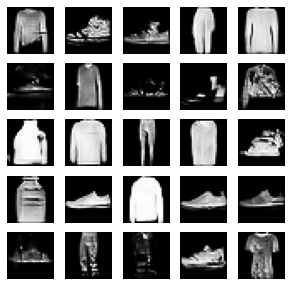

Time for epoch 50 is 48.0 sec
Epoch:  50 | Discriminator Loss:  0.55 | Accuracy:  69.79 % | Generator Loss:  1.39
---------------------------------------------------------------------------------------------------------------------------------------------------------------


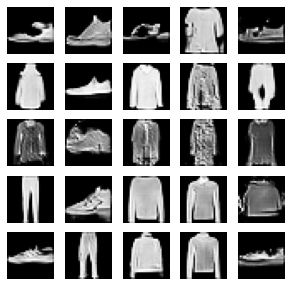

In [38]:
training()

In [42]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
generator.save("fashonMNIST_CNNgenerator")

discriminator.save("fashonMNIST_CNNdiscriminator")

gan.save("fashonMNIST_CNNgan")

INFO:tensorflow:Assets written to: fashonMNIST_CNNgenerator\assets
INFO:tensorflow:Assets written to: fashonMNIST_CNNdiscriminator\assets
INFO:tensorflow:Assets written to: fashonMNIST_CNNgan\assets


In [43]:
model = K.models.load_model("fashonMNIST_CNNgenerator")
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_12 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 128)      295040    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 128)     

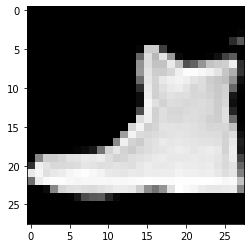

In [66]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
genImg = 127.5*genImg+127.5
plt.imshow(genImg[0,:,:,0],cmap="gray")
plt.show()